In [1]:
import os
from os import listdir
from os.path import isfile, join
R1000_file = './russell/1000'
R2000_file = './russell/2000'
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from dateutil.parser import parse
from statsmodels.stats.outliers_influence import summary_table
from linearmodels.iv import IV2SLS

%matplotlib notebook

In [2]:
R1000_filename= os.listdir(R1000_file)
R2000_filename=os.listdir(R2000_file)

In [63]:
R1000_list = pd.DataFrame(columns = ['Year','Ticker','Price'])
for file in R1000_filename:
    temp = pd.read_excel(os.path.join(os.getcwd(), R1000_file, file))
    temp = temp[['Ticker','Price']]
    temp['Ticker'] = temp['Ticker'].apply(lambda x: x[:-9])
    temp['Year'] = file[-10:-6]
    R1000_list = R1000_list.append(temp, ignore_index = True)

C:\Users\barry\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [64]:
R2000_list = pd.DataFrame(columns = ['Year','Ticker','Price'])
for file in R2000_filename:
    temp = pd.read_excel(os.path.join(os.getcwd(), R2000_file, file))
    temp = temp[['Ticker','Price']]
    temp['Ticker'] = temp['Ticker'].apply(lambda x: x[:-9])
    temp['Year'] = file[-10:-6]
    R2000_list = R2000_list.append(temp, ignore_index = True)

C:\Users\barry\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [24]:
IO = pd.read_csv('13F.csv')

C:\Users\barry\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:
R2000_list['Membership'] = 'R2000'
R1000_list['Membership'] = 'R1000'

Russell_all = R1000_list.append(R2000_list, ignore_index = True)

In [4]:
IO_russell = IO[IO['ticker'].apply(lambda x: x in Russell_all['Ticker'].unique())]

In [31]:
IO.set_index(['fdate','ticker'], inplace = True)
group = IO.groupby(['fdate','ticker'])

In [32]:
IO.head()

mgrname country  mgrno  typecode  \
fdate    ticker                                                          
20000331 NaN         ADVENT CAPITAL MANGEMENT     NaN    483         5   
         AAMB     M & I INVESTMENT MGMT CORP.     NaN  54280         5   
         AAON                ADVEST GROUP INC     NaN    485         4   
         AAON               BARCLAYS BANK PLC     NaN   7900         4   
         AAON    BRIDGEWAY CAPITAL MGMT, INC.     NaN  10042         5   

                    rdate  prdate     cusip   shares  sole  shared  no  \
fdate    ticker                                                          
20000331 NaN     20000331     NaN       NaN      NaN   NaN     NaN NaN   
         AAMB    20000331     NaN  00035730  11405.0   NaN     NaN NaN   
         AAON    20000331     NaN  00036020  10500.0   NaN     NaN NaN   
         AAON    20000331     NaN  00036020  85196.0   NaN     NaN NaN   
         AAON    20000331     NaN  00036020  50900.0   NaN     NaN NaN   

                  change      stkname exchcd stkcd  indcode stkcdesc    prc  \
fdate    ticker                                                               
20000331 NaN         NaN          NaN    NaN   NaN      NaN      NaN    NaN   
         AAMB        NaN  AAL MUT FDS    NaN   NaN      NaN      NaN  10.81   
         AAON        NaN     AAON INC    NaN   NaN      NaN      NaN  17.56   
         AAON      300.0     AAON INC    NaN   NaN      NaN      NaN  17.56   
         AAON    50900.0     AAON INC    NaN   NaN      NaN      NaN  17.56   

                 shrout1  shrout2  
fdate    ticker                    
20000331 NaN         NaN      NaN  
         AAMB        NaN      NaN  
         AAON        6.0      NaN  
         AAON        6.0      NaN  
         AAON        6.0      NaN

In [34]:
IO_shares = group.sum()['shares']

In [36]:
IO_total_share = group.first()[['prc','shrout1','shrout2']]

In [75]:
IO_percent = IO_shares / (IO_total_share['shrout1']*1000000)
IO_mktcap = IO_total_share['prc']*IO_total_share['shrout1']*1000000

In [46]:
IO_percent_clean = IO_percent.replace(np.inf,np.nan).dropna()

In [50]:
IO_output = IO_percent_clean.reset_index()
IO_output.columns = ['Date','Ticker','IO']
IO_output.to_excel('IO_output.xlsx')

In [53]:
IO_count = group.count()['shares']

In [5]:
#IO_count.replace(0, np.nan).dropna()

In [76]:
IO_sum = pd.DataFrame(index = IO_count.index, columns = ['count','percent','mktcap'])
IO_sum['count'] = IO_count
IO_sum['percent'] = IO_percent
IO_sum['mktcap'] = IO_mktcap

In [6]:
IO_sum.replace(np.inf, np.nan).dropna().reset_index().to_excel('IO_output.xlsx')

In [2]:
IO_sum = pd.read_excel('IO_output.xlsx')

In [3]:
IO_sum = IO_sum[IO_sum['percent'] <= 1]

In [4]:
print(IO_sum.describe().round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Unnamed: 0 &        fdate &      count &    percent &        mktcap \\
\midrule
count &   566071.00 &    566071.00 &  566071.00 &  566071.00 &  5.660710e+05 \\
mean  &   290182.09 &  20078371.62 &      81.63 &       0.30 &  7.461152e+09 \\
std   &   169107.37 &     51525.55 &     163.00 &       0.32 &  1.302741e+11 \\
min   &        0.00 &  20000331.00 &       1.00 &       0.00 &  0.000000e+00 \\
25\%   &   142789.50 &  20031231.00 &       3.00 &       0.01 &  3.499000e+07 \\
50\%   &   289679.00 &  20071231.00 &      21.00 &       0.17 &  1.972800e+08 \\
75\%   &   436756.50 &  20120630.00 &      92.00 &       0.56 &  1.269390e+09 \\
max   &   583744.00 &  20180630.00 &    2793.00 &       1.00 &  2.147614e+13 \\
\bottomrule
\end{tabular}



In [11]:
def wavg(group, avg_name, weight_name):
    
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [12]:
IO_sum.groupby('fdate').apply(wavg, 'percent', 'mktcap').plot()

In [5]:
IO_sum['fdate'] = IO_sum['fdate'].apply(lambda x: parse(str(x)))

In [14]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

### Plot of average institutional ownership, from 2000 to 2018

<IPython.core.display.Javascript object>


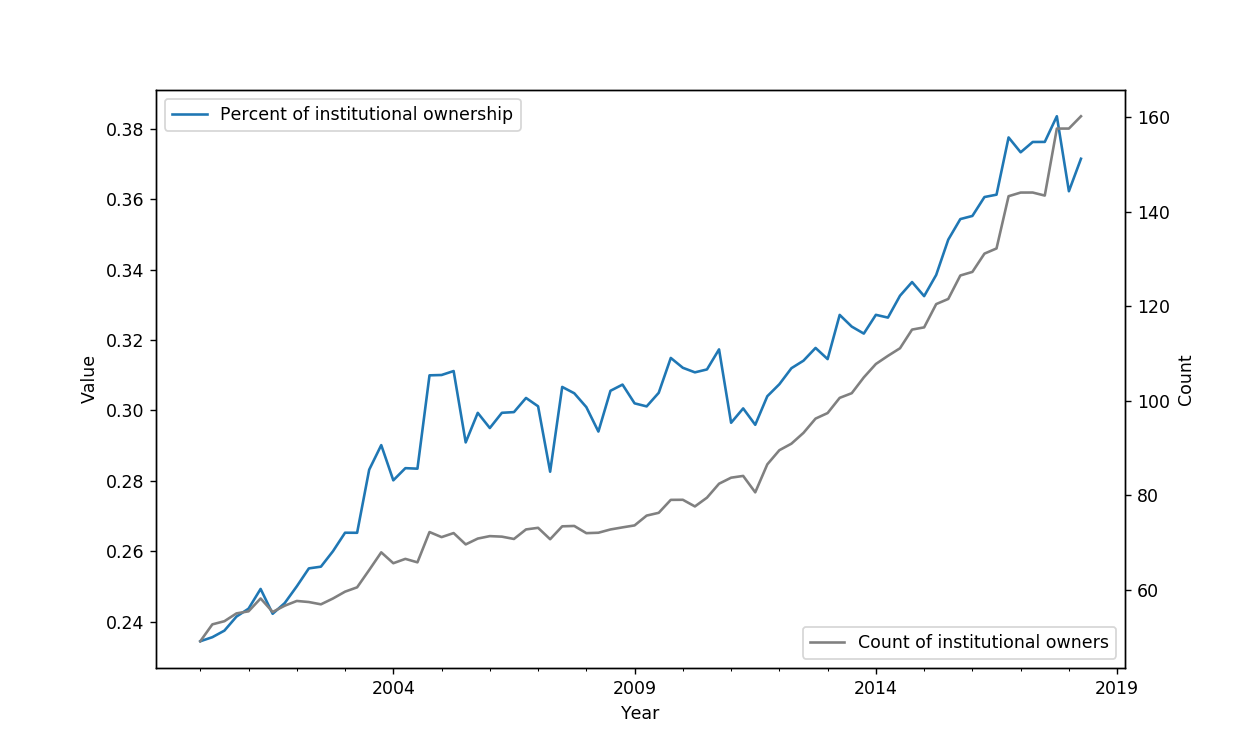

In [19]:
fig= plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
IO_sum.groupby('fdate').mean()['count'].plot(color = 'grey',ax = ax2,label = 'Count of institutional owners')
IO_sum.groupby('fdate').mean()['percent'].plot(kind = 'line',ax = ax1,label = 'Percent of institutional ownership')
#IO_sum.groupby('fdate').apply(wavg, 'percent','mktcap').plot(kind = 'line',ax = ax1,label = 'Percent of institutional ownership')
ax2.set_xlabel('Year')
ax2.set_ylabel('Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.legend(loc = 2)
ax2.legend(loc = 4)

### Read and summarize covariates

In [20]:
russell_cov = pd.read_csv('russell_tic_cov.csv')

In [21]:
russell_cov = russell_cov[['datadate','fyear','tic','csho','ni','revt','prcc_f']]

In [22]:
russell_cov['mktcap'] = russell_cov['csho']*russell_cov['prcc_f']

In [23]:
cov_sum = russell_cov.describe().round(2)
cov_sum['IO_count'] = IO_sum.describe().round(2)['count']
cov_sum['IO_percent'] = IO_sum.describe().round(2)['percent']
print(cov_sum.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &         mean &       std &          min &          25\% &          50\% &          75\% &          max \\
\midrule
datadate   &   65373.0 &  20090315.56 &  53887.56 &  20000630.00 &  20041231.00 &  20091231.00 &  20140630.00 &  20190228.00 \\
fyear      &   65373.0 &      2008.83 &      5.39 &      2000.00 &      2004.00 &      2009.00 &      2014.00 &      2018.00 \\
csho       &   65333.0 &       134.29 &    486.35 &         0.24 &        19.60 &        40.38 &        92.36 &     29058.36 \\
ni         &   65298.0 &       215.18 &   1609.12 &    -99289.00 &        -5.51 &        18.13 &       102.30 &     59531.00 \\
revt       &   65298.0 &      3408.37 &  14391.03 &     -4234.47 &       109.07 &       440.81 &      1776.41 &    514405.00 \\
prcc\_f     &   65372.0 &        29.34 &     62.96 &         0.00 &         8.36 &        18.86 &        35.55 &      4410.00 \\
mktcap     &   65332.0 &      5046.16 &  22548.42 &         0.0

### Read and summarize executive compensation outcomes

In [24]:
ExecuComp = pd.read_csv('ExecuComp_annual.csv', encoding = 'latin-1')

In [25]:
ExecuComp.columns
ExecuComp['year'] = ExecuComp['YEAR'].apply(lambda x: parse(str(x)))

In [26]:
print(ExecuComp[['SALARY','BONUS','STOCK_AWARDS','OPTION_AWARDS','OTHCOMP','LTIP','RSTKGRNT','TDC1']].describe().round(2).T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &      mean &          std &      min &     25\% &      50\% &      75\% &           max \\
\midrule
SALARY        &  199624.0 &   4381.93 &   1756103.01 &    -0.00 &  262.50 &   375.00 &   550.70 &  7.846150e+08 \\
BONUS         &  199624.0 &    222.60 &       913.75 &   -16.50 &    0.00 &     0.00 &   170.00 &  1.212714e+05 \\
STOCK\_AWARDS  &  131514.0 &  37300.64 &  13153122.85 & -7230.19 &   41.45 &   347.98 &  1046.30 &  4.769962e+09 \\
OPTION\_AWARDS &  131514.0 &    454.40 &      1668.21 & -3330.97 &    0.00 &    55.95 &   390.14 &  1.158840e+05 \\
OTHCOMP       &  199624.0 &    785.49 &    197858.40 & -4901.33 &    9.27 &    28.13 &    84.86 &  6.844358e+07 \\
LTIP          &   68110.0 &     90.23 &       691.88 &  -682.52 &    0.00 &     0.00 &     0.00 &  8.479999e+04 \\
RSTKGRNT      &   68110.0 &    275.28 &      1297.85 &     0.00 &    0.00 &     0.00 &    67.38 &  7.475000e+04 \\
TDC1          &  184675.0 &  22157.32 &  

<IPython.core.display.Javascript object>


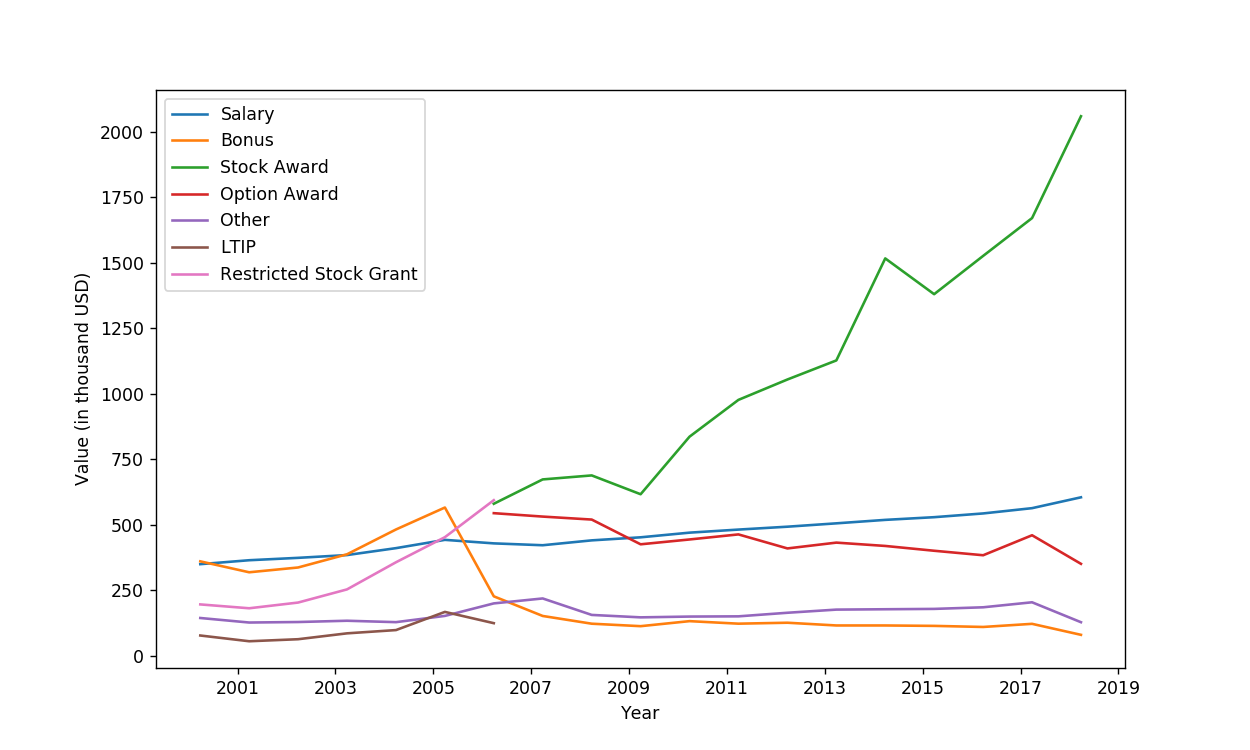

Text(0.5,0,'Year')

In [29]:
execu_plot = ExecuComp.groupby('year').mean()[['SALARY','BONUS','STOCK_AWARDS','OPTION_AWARDS','OTHCOMP','LTIP','RSTKGRNT']]
fig = plt.figure(figsize = (10,6))

plt.plot(execu_plot['SALARY'], label='Salary')
plt.plot(execu_plot['BONUS'], label='Bonus')
plt.plot(execu_plot['STOCK_AWARDS'], label='Stock Award')
plt.plot(execu_plot['OPTION_AWARDS'], label='Option Award')
plt.plot(execu_plot['OTHCOMP'], label='Other')
plt.plot(execu_plot['LTIP'], label='LTIP')
plt.plot(execu_plot['RSTKGRNT'], label='Restricted Stock Grant')
plt.legend(loc = 2)

plt.ylabel('Value (in thousand USD)')
plt.xlabel('Year')

In [28]:
#ExecuComp = ExecuComp.drop(66797).drop(73731)

In [30]:
ExecuComp_mean = ExecuComp.groupby(['year','TICKER']).mean()

In [7]:
#pd.DatetimeIndex(ExecuComp_mean.reset_index()['year']).year

In [32]:
IO_sum['year'] = pd.DatetimeIndex(IO_sum['fdate']).year

In [33]:
IO_sum_sum = IO_sum.set_index(['year','ticker'])

In [34]:
IO_sum_sum = IO_sum_sum.groupby(['year','ticker']).mean()

In [35]:
russell_cov['year'] = russell_cov['fyear'].apply(lambda x: parse(str(x)))

In [36]:
russell_cov['year'] = pd.DatetimeIndex(russell_cov['year']).year

In [37]:
russell_cov_fix = russell_cov.groupby(['year','tic']).first()
russell_cov_fix['IO_percent'] = IO_sum_sum['percent']*100
russell_cov_fix['IO_count'] = IO_sum_sum['count']

In [38]:
execucomp_panel = russell_cov_fix.copy()

In [39]:
ExecuComp_mean = ExecuComp_mean.reset_index()
ExecuComp_mean['year'] = pd.DatetimeIndex(ExecuComp_mean.reset_index()['year']).year

In [40]:
ExecuComp_mean = ExecuComp_mean.set_index(['year','TICKER'])

In [41]:
execucomp_panel[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other','Restricted']] = ExecuComp_mean[['SALARY','BONUS','STOCK_AWARDS','OPTION_AWARDS','TDC1','LTIP','OTHCOMP','RSTKGRNT']]

In [42]:
execucomp_panel

datadate  fyear      csho         ni        revt    prcc_f  \
year tic                                                                 
2000 A      20001031   2000   453.976    757.000   10773.000   46.3125   
     AAI    20001231   2000    65.823     47.436     624.094    7.2500   
     AAL    20001231   2000   152.063    813.000   19703.000   39.1875   
     AAN    20001231   2000    19.870     27.261     502.920   14.0625   
     AAON   20001231   2000     5.763     12.794     154.982   17.6875   
     AAPL   20000930   2000   335.677    786.000    7983.000   25.7500   
     AAWW   20001231   2000    38.167     85.259     790.468   32.6250   
     ABAX   20010331   2000    16.102      0.188      29.501    5.0313   
     ABC    20000930   2000    52.129     99.014   11645.021   47.0000   
     ABCB   20001231   2000     8.347     10.098      77.191    9.3750   
     ABCL   20001231   2000     9.243     19.644     151.339   23.0000   
     ABCRQ  20001231   2000    19.872    -56.201     482.230    6.0625   
     ABCW   20010331   2000    22.815     26.977     242.150   13.8750   
     ABDS   20001231   2000    26.713     -2.648      25.258    5.9375   
     ABEO   20001231   2000    12.844     -5.428       0.107    5.0000   
     ABF    20001231   2000    48.035     28.492    3275.950    9.7500   
     ABGX   20001231   2000    85.402     -8.793      26.601   59.0625   
     ABIZQ  20001231   2000    70.992   -309.824     351.974    4.2500   
     ABM    20001031   2000    22.999     44.343    1807.557   27.9375   
     ABMD   20010331   2000    20.771    -11.401      24.896   15.7500   
     ABT    20001231   2000  1545.934   2785.977   13745.916   48.4375   
     ABVT   20001231   2000   552.057   -407.241     188.152   10.1250   
     ACAS   20001231   2000    28.003     -4.373      62.728   25.1875   
     ACAT   20010331   2000    23.788     26.988     530.648   13.6875   
     ACCL   20001231   2000    23.411      1.175     116.891   21.8125   
     ACDO   20000630   2000    14.107      9.896     351.033   34.5625   
     ACET   20000630   2000     6.034      6.344     184.789   11.0000   
     ACFN   20001231   2000     7.045      0.112      57.839    4.1875   
     ACGL   20001231   2000    12.709     -8.012     123.498   15.0000   
     ACIW   20000930   2000    31.625      2.111     303.565   16.2500   
...              ...    ...       ...        ...         ...       ...   
2018 XELA   20181231   2018   150.143   -162.517    1586.222    3.8900   
     XENT   20181231   2018    30.529    -22.922     108.472   28.1800   
     XHR    20181231   2018   112.584    193.688    1058.207   17.2000   
     XOM    20181231   2018  4237.000  20840.000  279332.000   68.1900   
     XOMA   20181231   2018     8.691    -13.343       5.299   12.6500   
     XPER   20181231   2018    48.408     -0.289     406.133   18.3900   
     XPO    20181231   2018   115.683    422.000   17279.000   57.0400   
     XRAY   20181231   2018   223.000  -1011.000    3986.300   37.2100   
     XRX    20181231   2018   229.623    361.000    9830.000   19.7600   
     XYL    20181231   2018   179.700    549.000    5207.000   66.7200   
     Y      20181231   2018    14.577     39.539    6873.460  623.3200   
     YELP   20181231   2018    81.997     55.350     942.773   34.9900   
     YEXT   20190131   2018   102.173    -74.837     228.283   15.5900   
     YRCW   20181231   2018    33.849     24.500    5092.000    3.1500   
     YUM    20181231   2018   306.000   1542.000    5688.000   91.9200   
     Z      20181231   2018   203.903   -119.858    1333.554   31.5800   
     ZAGG   20181231   2018    27.474     39.189     538.231    9.7800   
     ZAYO   20180630   2018   246.438    101.900    2604.000   36.4800   
     ZBH    20181231   2018   204.000   -379.200    7932.900  103.7200   
     ZBRA   20181231   2018    53.871    421.000    4218.000  159.2300   
     ZEN    20181231   2018   108.000   -131.084     598.746   58.3700   
     ZEUS   2018

In [47]:
#execucomp_panel[['ni','revt']] = execucomp_panel[['ni','revt']]/1000
#execucomp_panel['mktcap'] = execucomp_panel['mktcap']*1000
#execucomp_panel['IO'] = execucomp_panel['IO'] * 100
execucomp_panel['IO_count'] = IO_sum_sum['count']

### OLS regression of executive compensation on institutional ownership

In [48]:
Y_variable = ['salary','bonus','Stock_award','Option_award','TDC1']#,'LTIP','Restricted']
X1 = ['IO_count']
X2 = ['IO_count','ni','revt','mktcap']

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

reg_list = []
for y in Y_variable:
    reg_list.append(smf.ols(y+'~ IO_percent + C(fyear)', data = execucomp_panel).fit())
    reg_list.append(smf.ols(y+'~ IO_percent + ni + revt + mktcap + C(fyear)', data = execucomp_panel).fit())

results_table = summary_col(results=reg_list,
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Salary',
                                         'Salary',
                                         'Bonus',
                                        'Bonus',
                                        'Stock_award','Stock_award',
                                        'Option_award','Option_award',
                                        'Total','Total'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'IO_count',
                                             'ni',
                                             'revt',
                                             'mktcap'])


In [49]:
results_table.add_title('OLS Regressions: Executive Compensation on Institutional Ownership')
print(results_table.as_latex())

\begin{table}
\caption{OLS Regressions: Executive Compensation on Institutional Ownership} \\
\begin{center}
\begin{tabular}{lcccccccccc}
\hline
                 &  Salary I & Salary II &  Bonus I   &  Bonus II  & Stock\_award I & Stock\_award II & Option\_award I & Option\_award II &   Total I   &   Total II   \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllllllll}
IO\_count        & 0.49***   & 0.50***   & 0.60***    & 0.24***    & 3.21***        & 1.59***         & 1.37***         & 1.51***          & 7.27***     & 5.40***      \\
                 & (0.00)    & (0.01)    & (0.02)     & (0.03)     & (0.04)         & (0.06)          & (0.03)          & (0.06)           & (0.07)      & (0.11)       \\
ni               &           & 0.71      &            & 23.83***   &                & 8.48            &                 & -39.94***        &             & -87.33***    \\
                 &           & (0.83)    &            & (3.16)     &                & (7.25)          &           

### OLS regression of executive compensation on institutional ownership

In [50]:
BoardEx_comp_avg_public = pd.read_excel('BoardEx_use.xlsx')

BoardEx_comp_avg_public['Year'] = BoardEx_comp_avg_public['AnnualReportDate'].apply(lambda x:parse(str(x)[:4]))

In [51]:
BoardEx_comp_avg_public['year'] = pd.DatetimeIndex(BoardEx_comp_avg_public['Year']).year
BoardEx_use = BoardEx_comp_avg_public.groupby(['year','Ticker']).first()

In [52]:
boardex_panel = russell_cov_fix.copy()

In [53]:
boardex_panel[['Salary','Bonus','LTIP','Option','Total']] = BoardEx_use[['Salary','Bonus','LTIPValue','EstValOptHeld','TotalCompensation']]
#boardex_panel[['ni','revt','mktcap']] = boardex_panel[['ni','revt','mktcap']]/1000
#execucomp_panel['mktcap'] = execucomp_panel['mktcap']*1000

In [54]:
Y_variable = ['Salary','Bonus','LTIP','Option','Total']#,'LTIP','Restricted']

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

reg_list = []
for y in Y_variable:
    reg_list.append(smf.ols(y+'~ IO_count + C(fyear)', data = boardex_panel).fit())
    reg_list.append(smf.ols(y+'~ IO_count + ni + revt + mktcap + C(fyear)', data = boardex_panel).fit())

results_table = summary_col(results=reg_list,
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Salary',
                                         'Salary',
                                         'Bonus',
                                        'Bonus',
                                        'LTIP','LTIP',
                                        'Option','Option',
                                        'Total','Total'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'IO_count',
                                             'ni',
                                             'revt',
                                             'mktcap'])


In [55]:
print(results_table.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccccccc}
\hline
                 &  Salary I & Salary II &  Bonus I   &  Bonus II &    LTIP I   &  LTIP II   &   Option I   &  Option II   &  Total I   &  Total II   \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllllllll}
IO\_count        & 0.07***   & 0.05***   & 2.46***    & 1.94***   & 1.77***     & 1.37***    & 51.27***     & 36.63***     & 0.20***    & 0.11***     \\
                 & (0.00)    & (0.01)    & (0.15)     & (0.25)    & (0.28)      & (0.44)     & (3.36)       & (5.45)       & (0.01)     & (0.02)      \\
ni               &           & 0.85*     &            & 73.59**   &             & 39.45      &              & -1601.89***  &            & 4.50**      \\
                 &           & (0.51)    &            & (33.55)   &             & (41.99)    &              & (515.21)     &            & (1.98)      \\
revt             &           & -0.02     &            & 1.22      &             & 1.40       &        

In [361]:
IO_sum_sum.to_excel('IO_sum.xlsx')

In [362]:
boardex_panel.to_excel('Boardex_OLS.xlsx')

In [363]:
execucomp_panel.to_excel('Execucomp_OLS.xlsx')

In [8]:
IO_sum_sum = pd.read_excel('IO_sum.xlsx')

### Read end of May market cap data

In [56]:
mktcap_file = './Marketcap May'
mktcap_filename = os.listdir(mktcap_file)

In [57]:
MktCap_may = pd.DataFrame(columns = ['TICKER','Year','MarketCap','Rank'])
for file in mktcap_filename:
    temp = pd.read_csv(os.path.join(os.getcwd(), mktcap_file, file))
    temp['MarketCap'] = temp['PRC']*temp['SHROUT']
    temp['Year'] = parse(file[:4]).year
    temp['Rank'] = temp['MarketCap'].rank(ascending = False)
    MktCap_may = MktCap_may.append(temp[['TICKER','Year','MarketCap','Rank']])

In [61]:
MktCap_may.to_excel('MktCap_may.xlsx')

In [7]:
MktCap_may = pd.read_excel('MktCap_may.xlsx')

In [8]:
MktCap_may['Year'] = MktCap_may['Year'].astype(int)
MktCap_may_indexed = MktCap_may.groupby(['TICKER','Year']).first()

In [66]:
Russell_all['R1000'] = Russell_all['Membership'] == 'R1000'

In [67]:
#Russell_all['Ticker'] = Russell_all['Ticker'].apply(lambda x: x[:-1])

In [9]:
MktCap_may[MktCap_may['Year'] == 2000]['MarketCap'].rank(ascending = False)
#MktCap_may[MktCap_may['Year'] == 2000]['Rank']

In [69]:
Russell_all['year'] = Russell_all['Year'].apply(lambda x: parse(x).year)
Russell_all['year'] = Russell_all['year'].astype(int)
#MktCap_may_indexed.loc[['ZUMZ',]]

In [1133]:
MktCap_may_indexed['R1000'] = Russell_all.groupby(['Ticker','year']).first()['R1000']

In [71]:
Russell_all['Ticker']
MktCap_may['TICKER'].unique().shape

(7095,)

In [72]:
MktCap_may_indexed['R1000'] = MktCap_may_indexed['R1000'].astype(float)
MktCap_may_all = MktCap_may_indexed.reset_index()


### Plot of Russell 2000 index membership against end of May market cap rank

For before and after 2007

<IPython.core.display.Javascript object>


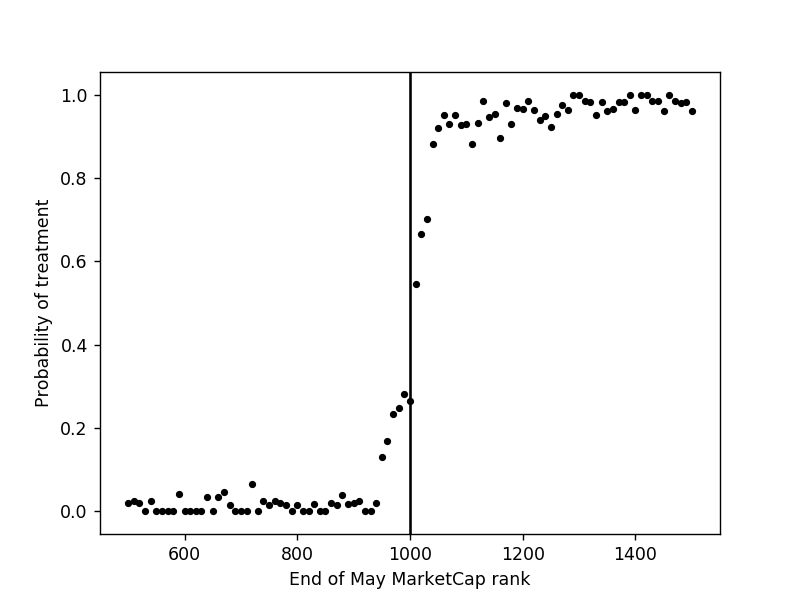

In [598]:
Mktcap_pre2007 = MktCap_may_all[MktCap_may_all['Year'] < 2007].groupby('Rank').mean()
values = Mktcap_pre2007.groupby(np.arange(len(Mktcap_pre2007)) // 10).mean().loc[40:140].reset_index()
fig = plt.figure()
plt.scatter(np.linspace(500,1500,101),y = 1-values['R1000'], s = 10,c='k')
#plt.title('Probability of receiving Russell 1000 index membership, pre-2007')
plt.xlabel('End of May MarketCap rank')
plt.ylabel('Probability of treatment')
plt.axvline(1000, c='k')
plt.show()


<IPython.core.display.Javascript object>


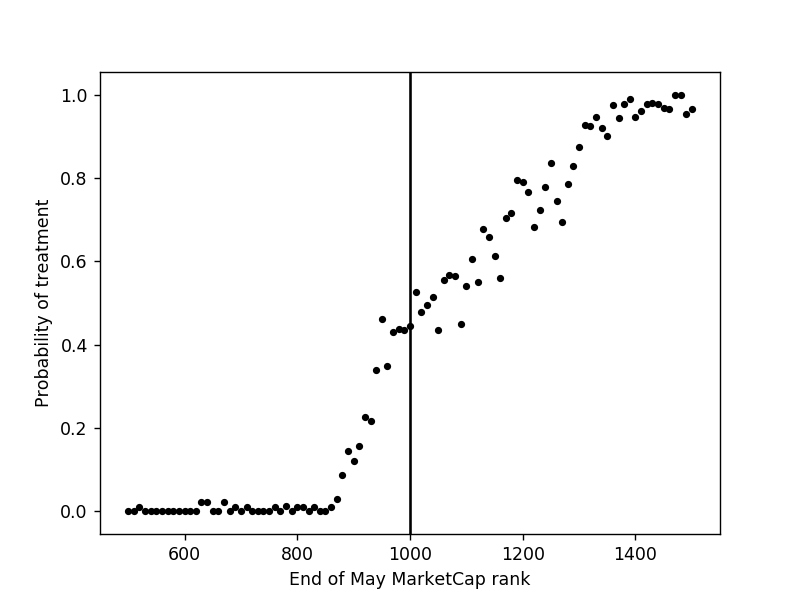

In [599]:
Mktcap_post2007 = MktCap_may_all[MktCap_may_all['Year'] > 2007].groupby('Rank').mean()
values = Mktcap_post2007.groupby(np.arange(len(Mktcap_post2007)) // 10).mean().loc[40:140].reset_index()
fig = plt.figure()
plt.scatter(np.linspace(500,1500,101),y = 1-values['R1000'], s = 10,c='k')
plt.xlabel('End of May MarketCap rank')
plt.ylabel('Probability of treatment')
plt.axvline(1000, c='k')
plt.show()

### RDD plot for executive compensation variables and other covariates

In [77]:
execucomp_panel[['Mktcap_may','Rank','R1000']] = MktCap_may_indexed.reset_index().set_index(['Year','TICKER'])[['MarketCap','Rank','R1000']]

In [78]:
execu_meanbyrank = execucomp_panel.groupby(['Rank','fyear']).mean().reset_index()#.loc[800:1200].reset_index().plot.scatter(x = 'Rank',y='IO')

In [694]:
execu_pre2007 = execu_meanbyrank[execu_meanbyrank['fyear'] < 2007].groupby('Rank').mean()#.reset_index().plot.scatter(x = 'Rank',y='salary')
execu_post2007 = execu_meanbyrank[execu_meanbyrank['fyear'] >= 2007].groupby('Rank').mean()

In [8]:
#execu_pre2007_bin[['ni','revt']] = execu_pre2007_bin[['ni','revt']]*1000000
execu_pre2007_bin['ni_share'] = execu_pre2007_bin['ni'] / execu_pre2007_bin['mktcap']
execu_pre2007_bin['revt_share'] = execu_pre2007_bin['revt'] / execu_pre2007_bin['mktcap']

fig = plt.figure()
plt.scatter(x = execu_pre2007_bin.reset_index()['index']*10, y = execu_pre2007_bin.reset_index()['revt_share'], c ='k')
plt.xlabel('End of May Market Cap rank')
plt.ylabel('Revenue as share of market cap')
plt.axvline(1000,c='k')
plt.show()

In [83]:
execu_pre2007_bin = execu_pre2007.groupby(np.arange(len(execu_pre2007)) // 10).mean().loc[80:120]

In [90]:
execu_pre2007_bin['salary_share'] = execu_pre2007_bin['salary'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['bonus_share'] = execu_pre2007_bin['bonus'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['stock_share'] = execu_pre2007_bin['Stock_award'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['option_share'] = execu_pre2007_bin['Option_award'] / execu_pre2007_bin['TDC1']

<IPython.core.display.Javascript object>


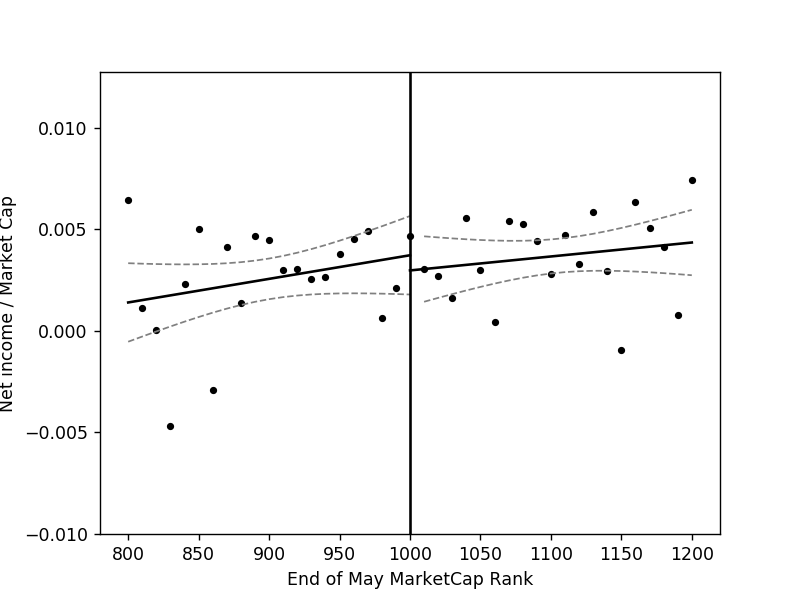

Text(0,0.5,'Net income / Market Cap')

In [1184]:
start = 800
end = 1200
middle = (start+end)/2

name = 'nishare'
execu_pre2007_bin = execu_pre2007.groupby(np.arange(len(execu_pre2007)) // 10).mean().loc[start/10:end/10]
execu_pre2007_bin['rank'] = execu_pre2007_bin.index*10
execu_pre2007_bin = execu_pre2007_bin.set_index('rank')

execu_pre2007_bin['salary_share'] = execu_pre2007_bin['salary'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['bonus_share'] = execu_pre2007_bin['bonus'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['stock_share'] = execu_pre2007_bin['Stock_award'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['option_share'] = execu_pre2007_bin['Option_award'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['LTIP_share'] = execu_pre2007_bin['LTIP'] / execu_pre2007_bin['TDC1']
execu_pre2007_bin['Other_share'] = execu_pre2007_bin['Other'] / execu_pre2007_bin['TDC1']

execu_pre2007_bin = execu_pre2007_bin.set_index(execu_pre2007_bin.index[::-1])[::-1]

execu_pre2007_bin['nishare'] = execu_pre2007_bin['ni']*100000 / execu_pre2007_bin['Mktcap_may']
execu_pre2007_bin['reveshare'] = execu_pre2007_bin['revt']*100000 / execu_pre2007_bin['Mktcap_may']


model1 = smf.ols(name + ' ~ rank', data = execu_pre2007_bin.loc[start:middle].reset_index()).fit()
coef1 = model1.params.values
model2 = smf.ols(name +' ~ rank', data = execu_pre2007_bin.loc[middle+10:end].reset_index()).fit()
coef2 = model2.params.values
execu_pre2007_bin.reset_index().plot.scatter(x = 'rank', y = name, s = 10, c='k')
fit_pre = (execu_pre2007_bin.loc[start:middle].reset_index()['rank']*coef1[1]+coef1[0]).values
fit_post = (execu_pre2007_bin.loc[middle:end].reset_index()['rank']*coef2[1]+coef2[0]).values

x_pre = np.arange(start,middle+10, 10)
x_post = np.arange(middle,end+10,10)
plt.plot(x_pre,fit_pre, c = 'k')
st, data, ss2 = summary_table(model1, alpha=0.1)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_pre, predict_mean_ci_low, '--', lw=1, color = 'grey')
plt.plot(x_pre, predict_mean_ci_upp, '--', lw=1, color = 'grey')
#plt.xticks(list(np.arange(800,1200,41)))

plt.plot(x_post,fit_post, c = 'k')
st, data, ss2 = summary_table(model2, alpha=0.1)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_post[1:], predict_mean_ci_low, '--', lw=1, color = 'grey')
plt.plot(x_post[1:], predict_mean_ci_upp, '--', lw=1, color = 'grey')
plt.axvline(middle, c='k')
plt.xlabel('End of May MarketCap Rank')
plt.ylabel('Net income / Market Cap')



### RDD plot for institutional ownership

In [10]:
IO_sum['quarter'] = IO_sum['fdate'].apply(lambda x: x.quarter)

In [14]:
IO_sum['year'] = IO_sum['fdate'].apply(lambda x: x.year)

In [15]:
IO_sum_with_russell = IO_sum.set_index(['year','ticker'])
IO_sum_with_russell[['Mktcap_may','Rank']] = MktCap_may_indexed.reset_index().set_index(['Year','TICKER'])[['MarketCap','Rank']]

In [16]:
temp = IO_sum_with_russell[IO_sum_with_russell['quarter'] == 2].loc[:2007].groupby('Rank').mean()#.loc[800:1200].groupby().reset_index().plot.scatter(x = 'Rank', y = 'percent')

In [37]:
IO_pre2007['T'] = (IO_pre2007.index > 1000).astype(int)
IO_pre2007['Rank'] = IO_pre2007.index - 1000
IO_pre2007['RankT'] = IO_pre2007['T']*IO_pre2007['Rank']

In [10]:
#IO_pre2007

In [11]:
#model = smf.ols('percent ~ T + Rank + RankT', data = IO_pre2007.loc[start:middle].reset_index())
#model.fit().summary()

<IPython.core.display.Javascript object>


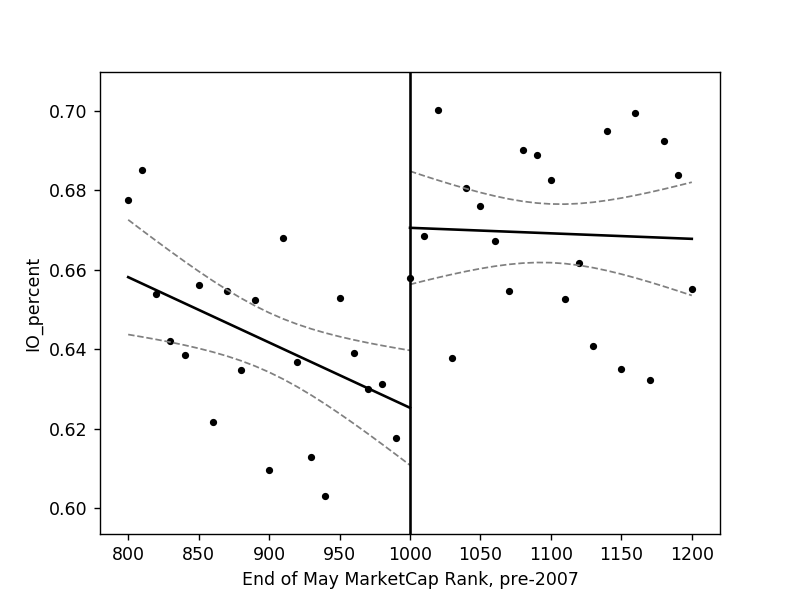

Text(0, 0.5, 'IO_percent')

In [31]:
start = 800
end = 1200
middle = (start+end)/2

IO_pre2007 = temp.groupby(np.arange(len(temp)) // 10).mean().loc[start/10:end/10]
IO_pre2007['rank'] = IO_pre2007.index*10
IO_pre2007 = IO_pre2007.set_index('rank')

IO_pre2007 = IO_pre2007.set_index(IO_pre2007.index[::-1])[::-1]
model1 = smf.ols('percent ~ rank', data = IO_pre2007.loc[start:middle].reset_index()).fit()
coef1 = model1.params.values
model2 = smf.ols('percent ~ rank', data = IO_pre2007.loc[middle:end].reset_index()).fit()
coef2 = model2.params.values
IO_pre2007.reset_index().plot.scatter(x = 'rank', y = 'percent', s = 10, c='k')
fit_pre = (IO_pre2007.loc[start:middle].reset_index()['rank']*coef1[1]+coef1[0]).values
fit_post = (IO_pre2007.loc[middle:end].reset_index()['rank']*coef2[1]+coef2[0]).values

x_pre = np.arange(start,middle + 10,10)
x_post = np.arange(middle,end+10,10)
plt.plot(x_pre,fit_pre,color='k')
st, data, ss2 = summary_table(model1, alpha=0.1)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_pre, predict_mean_ci_low, '--', lw=1,color='grey')
plt.plot(x_pre, predict_mean_ci_upp, '--', lw=1,color='grey')


plt.plot(x_post,fit_post,color = 'k')
st, data, ss2 = summary_table(model2, alpha=0.15)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_post, predict_mean_ci_low, '--', lw=1, color='grey')
plt.plot(x_post, predict_mean_ci_upp, '--', lw=1,color='grey')
plt.axvline(middle, color='k')
plt.xlabel('End of May MarketCap Rank, pre-2007')
plt.ylabel('IO_percent')

### RDD plot for board member compensation

In [92]:
boardex_panel[['Mktcap_may','Rank','R1000']] = MktCap_may_indexed.reset_index().set_index(['Year','TICKER'])[['MarketCap','Rank','R1000']]

In [659]:
boardex_meanbyrank = boardex_panel.groupby(['Rank','fyear']).mean().reset_index()
boardex_pre2007 = boardex_meanbyrank[boardex_meanbyrank['fyear'] < 2007].groupby('Rank').mean()
boardex_pre2007.columns

Index(['fyear', 'datadate', 'csho', 'ni', 'revt', 'prcc_f', 'mktcap',
       'IO_percent', 'IO_count', 'Salary', 'Bonus', 'LTIP', 'Option', 'Total',
       'Mktcap_may', 'R1000', 'constant', 'LogMktcap', 'LogMktcap_may',
       'salary_share', 'bonus_share', 'LTIP_share', 'Option_share'],
      dtype='object')

In [12]:
#boardex_pre2007_bin#set_index(boardex_pre2007_bin.index[::-1])

<IPython.core.display.Javascript object>


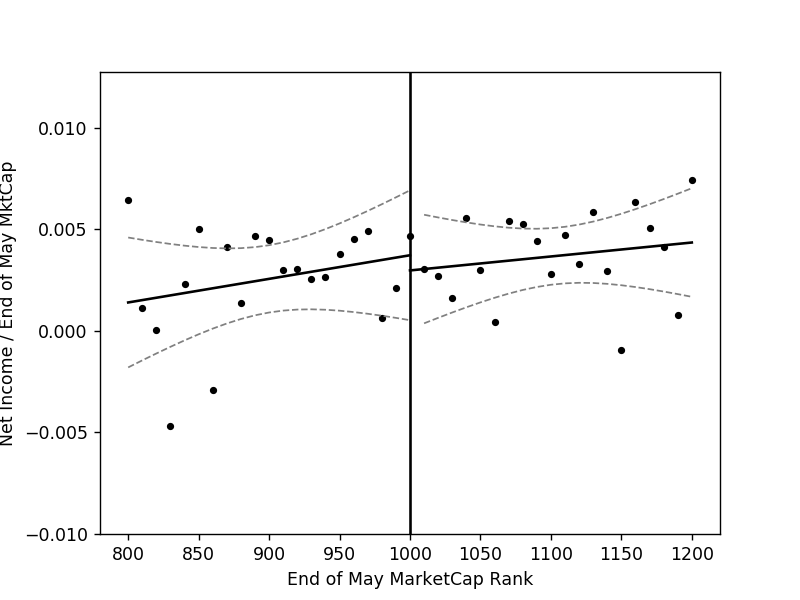

In [1190]:
start = 800
end = 1200
middle = (start+end)/2

name = 'nishare'
boardex_pre2007_bin = boardex_pre2007.groupby(np.arange(len(boardex_pre2007)) // 10).mean().loc[start/10:end/10]
boardex_pre2007_bin['rank'] = boardex_pre2007_bin.index*10
boardex_pre2007_bin = boardex_pre2007_bin.set_index('rank')

boardex_pre2007_bin['salary_share'] = boardex_pre2007_bin['Salary'] / boardex_pre2007_bin['Total']
boardex_pre2007_bin['bonus_share'] = boardex_pre2007_bin['Bonus'] / boardex_pre2007_bin['Total']
boardex_pre2007_bin['option_share'] = boardex_pre2007_bin['Option'] / boardex_pre2007_bin['Total']
boardex_pre2007_bin['LTIP_share'] = boardex_pre2007_bin['LTIP'] / boardex_pre2007_bin['Total']
#boardex_pre2007_bin['Other_share'] = boardex_pre2007_bin['Other'] / boardex_pre2007_bin['TDC1']

boardex_pre2007_bin['nishare'] = boardex_pre2007_bin['ni']*100000 / boardex_pre2007_bin['Mktcap_may']
boardex_pre2007_bin['reveshare'] = boardex_pre2007_bin['revt']*100000 / boardex_pre2007_bin['Mktcap_may']

boardex_pre2007_bin = boardex_pre2007_bin.set_index(boardex_pre2007_bin.index[::-1])[::-1]
model1 = smf.ols(name + ' ~ rank', data = boardex_pre2007_bin.loc[start:middle].reset_index()).fit()
coef1 = model1.params.values
model2 = smf.ols(name +' ~ rank', data = boardex_pre2007_bin.loc[middle+1:end].reset_index()).fit()
coef2 = model2.params.values
boardex_pre2007_bin.reset_index().plot.scatter(x = 'rank', y = name, s = 10, c='k')
fit_pre = (boardex_pre2007_bin.loc[start:middle].reset_index()['rank']*coef1[1]+coef1[0]).values
fit_post = (boardex_pre2007_bin.loc[middle:end].reset_index()['rank']*coef2[1]+coef2[0]).values

x_pre = np.arange(start,middle+10, 10)
x_post = np.arange(middle,end+10,10)
plt.plot(x_pre,fit_pre, c='k')
st, data, ss2 = summary_table(model1, alpha=0.01)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_pre, predict_mean_ci_low, '--', lw=1, color = 'grey')
plt.plot(x_pre, predict_mean_ci_upp, '--', lw=1, color = 'grey')


plt.plot(x_post,fit_post, c='k')
st, data, ss2 = summary_table(model2, alpha=0.01)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_post[1:], predict_mean_ci_low, '--', lw=1, color = 'grey')
plt.plot(x_post[1:], predict_mean_ci_upp, '--', lw=1, color = 'grey')
plt.xlabel('End of May MarketCap Rank')
plt.ylabel('Net Income / End of May MktCap')
plt.axvline(middle, c='k')


### Line plot for end of May market cap

<IPython.core.display.Javascript object>


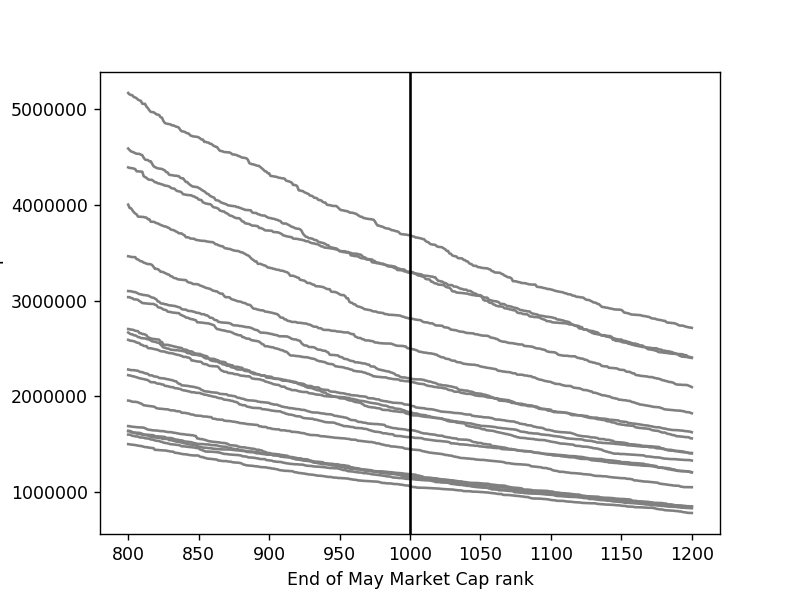

In [105]:
for year in MktCap_may_indexed.reset_index()['Year'].unique():
    MktCap_may_indexed.reset_index().groupby('Year').get_group(year).set_index('Rank').sort_index().loc[800:1200]['MarketCap'].plot(c = 'grey')
plt.xlabel('End of May Market Cap rank')
plt.ylabel('Market Cap')
plt.axvline(1000,c='k')
plt.show()

In [1156]:
MktCap_may_indexed = MktCap_may.reset_index()
MktCap_may_indexed['Rank'] = MktCap_may_indexed.groupby('Year')['MarketCap'].rank(ascending = False)

### RDD plot for end of May market cap

In [13]:
#MktCap_may_indexed2.groupby(np.arange(len(MktCap_may_indexed2)) // 10).mean().loc[start/10:end/10]


<IPython.core.display.Javascript object>


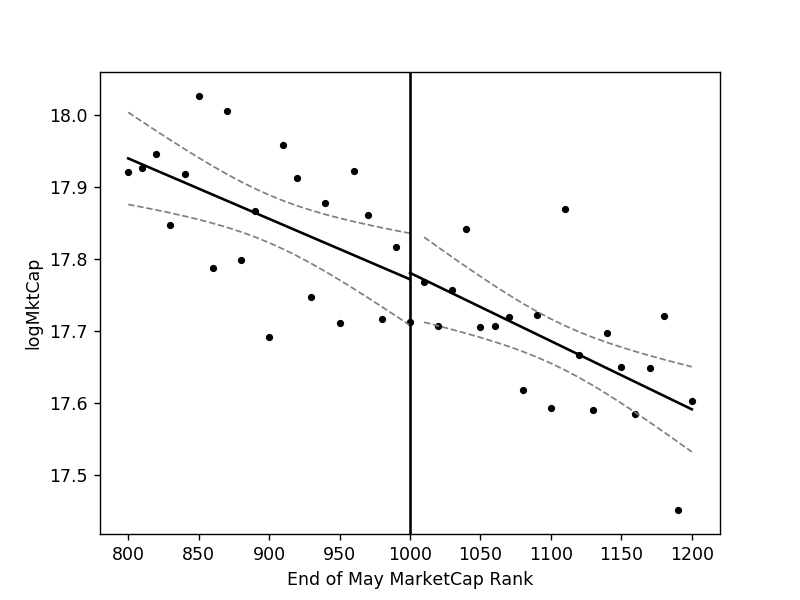

In [1175]:
start = 800
end = 1200
middle = (start+end)/2

MktCap_may_indexed2 = MktCap_may_indexed.reset_index().set_index('Rank')
MktCap_may_indexed2 = MktCap_may_indexed2.sort_index()
MktCap_may_indexed_bin = MktCap_may_indexed2.groupby(np.arange(len(MktCap_may_indexed2)) // 10).mean().loc[start/10:end/10]
MktCap_may_indexed_bin['rank'] = MktCap_may_indexed_bin.index*10
MktCap_may_indexed_bin = MktCap_may_indexed_bin.set_index('rank')
MktCap_may_indexed_bin['logMktCap'] = np.log(MktCap_may_indexed_bin['MarketCap'])

name = 'logMktCap'
model1 = smf.ols(name + ' ~ rank', data = MktCap_may_indexed_bin.loc[start:middle].reset_index()).fit()
coef1 = model1.params.values
model2 = smf.ols(name +' ~ rank', data = MktCap_may_indexed_bin.loc[middle+1:end].reset_index()).fit()
coef2 = model2.params.values

MktCap_may_indexed_bin.reset_index().plot.scatter(x = 'rank', y = name, s = 10, c='k')
fit_pre = (MktCap_may_indexed_bin.loc[start:middle].reset_index()['rank']*coef1[1]+coef1[0]).values
fit_post = (MktCap_may_indexed_bin.loc[middle:end].reset_index()['rank']*coef2[1]+coef2[0]).values

x_pre = np.arange(start,middle+10, 10)
x_post = np.arange(middle,end+10,10)
plt.plot(x_pre,fit_pre, c='k')
st, data, ss2 = summary_table(model1, alpha=0.1)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_pre, predict_mean_ci_low, '--', lw=1, color = 'grey')
plt.plot(x_pre, predict_mean_ci_upp, '--', lw=1, color = 'grey')


plt.plot(x_post,fit_post, c='k')
st, data, ss2 = summary_table(model2, alpha=0.1)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_post[1:], predict_mean_ci_low, '--', lw=1, color = 'grey')
plt.plot(x_post[1:], predict_mean_ci_upp, '--', lw=1, color = 'grey')
plt.xlabel('End of May MarketCap Rank')
plt.axvline(middle, c='k')


In [109]:
boardex_panel.reset_index().to_excel('boardex_panel.xlsx')

In [110]:
execucomp_panel.reset_index().to_excel('execucomp_panel.xlsx')

In [14]:
#execucomp_panel[execucomp_panel['Rank'].apply(lambda x: all([x < 1200, x>800]))].reset_index()

In [15]:
# temp_2 = execucomp_panel.reset_index()[execucomp_panel.reset_index()['year'] < 2007]
# execu_reg_pre2007 = temp_2[temp_2['Rank'].apply(lambda x: all([x<1200,x>800]))]

# model = smf.ols('IO_percent ~ R1000 + Mktcap_may + C(year)', data = execu_reg_pre2007) 
# model.fit().summary()

In [328]:
execucomp_panel_use = execucomp_panel.reset_index()[execucomp_panel.reset_index()['year']<2007][execucomp_panel.reset_index()[execucomp_panel.reset_index()['year']<2007]['Rank'].apply(lambda x: all([x>800,x<1200]))].set_index('Rank')

In [16]:
# def update_num(panel, name,loc, num):
    
#     panel.loc[range(loc-5,loc+5), name] = num
#     return panel

### Second stage regression result for executive compensation

In [831]:
execucomp_panel_use['Rank'] = execucomp_panel_use.index

In [832]:
execucomp_panel_use['constant'] = 1
execucomp_panel_use['LogMktcap'] = np.log(execucomp_panel_use['mktcap'])
execucomp_panel_use['LogMktcap_may'] = np.log(execucomp_panel_use['Mktcap_may'])

Y_variable = ['salary_share','bonus_share','stock_share','option_share','LTIP_share','Other_share']

reg_list = []
for Y in Y_variable:
    IV = IV2SLS(dependent= execucomp_panel_use[Y],
            exog = execucomp_panel_use[['LogMktcap','ni','revt','constant','year']],
            endog = execucomp_panel_use['IO_count'],
            instruments = execucomp_panel_use[['R1000','Rank']]).fit(cov_type='unadjusted')
    reg_list.append(IV)
    

C:\Users\barry\Anaconda3\lib\site-packages\linearmodels\utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [833]:
result = pd.DataFrame(index = ['IO_count','IO_countstd','LogMktcap','LogMktcapstd',
                                'ni','nistd','revt','revtstd','constant','constantstd','No. observations','R-squared'])
for (i,y) in enumerate(Y_variable):
    std = reg_list[i].std_errors.round(2).reset_index()
    std.index = std['index'].apply(lambda x: x+'std')
    std = std['stderr'].astype(str).apply(lambda x: '(' + x + ')')
    result[y] = reg_list[i].params.round(2).append(std)
    result[y]['No. observations'] = reg_list[i].nobs
    result[y]['R-squared'] = np.abs(np.round(reg_list[i].rsquared,2))

In [834]:
print(result.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & salary\_share & bonus\_share & stock\_share & option\_share & LTIP\_share & Other\_share \\
\midrule
IO\_count         &        -0.07 &       -0.04 &       -0.54 &        -0.28 &       0.01 &       -0.01 \\
IO\_countstd      &       (0.06) &      (0.06) &       (0.3) &       (0.23) &     (0.03) &      (0.03) \\
LogMktcap        &         -1.4 &        4.32 &        2.67 &        10.78 &       0.75 &        1.06 \\
LogMktcapstd     &       (2.48) &      (2.21) &      (14.4) &      (11.63) &      (0.9) &      (1.16) \\
ni               &         1.54 &        8.72 &        6.72 &        -4.15 &       1.26 &        2.11 \\
nistd            &       (2.78) &      (2.48) &      (9.55) &        (7.5) &     (1.27) &       (1.3) \\
revt             &         0.16 &        0.52 &        0.16 &        -0.28 &       0.28 &        0.21 \\
revtstd          &       (0.26) &      (0.23) &      (0.93) &       (0.68) &     (0.11) &      (0.12) \\
constant         &

In [18]:
IO_temp = IO_sum_with_russell.loc[:2007]
IO_temp['IO_percent'] = IO_temp['percent']*100
IO_temp['Year'] = IO_temp['fdate'].apply(lambda x:x.year).loc[range(700,1300)]
IO_temp.reset_index().set_index('Rank')
IO_temp = IO_temp.reset_index().set_index('Rank')
IO_temp2 = IO_temp[IO_temp['quarter'] == 2]
IO_temp3 = IO_temp[IO_temp['quarter'] == 3]
IO_temp4 = IO_temp[IO_temp['quarter'] == 4]

# center rank
IO_temp2['Rank'] = IO_temp2.index - 1000
IO_temp3['Rank'] = IO_temp3.index - 1000
IO_temp4['Rank'] = IO_temp4.index - 1000

# dummy for rank above 1000
IO_temp2['T'] = IO_temp2['Rank'] > 0
IO_temp3['T'] = IO_temp3['Rank'] > 0
IO_temp4['T'] = IO_temp4['Rank'] > 0


In [17]:
#model = smf.ols('IO_percent ~ R1000 + np.log(Mktcap_may) + C(Year)', data = IO_temp4).fit()
#model.summary()

### Intermediate first stage regression

In [19]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

reg_list = []
reg_list.append(smf.ols('IO_percent ~ T + Rank + T*Rank + C(Year)', data = IO_temp2.loc[range(800,1200)]).fit())
reg_list.append(smf.ols('IO_percent ~ T + Rank + T*Rank +C(Year)', data = IO_temp3.loc[range(800,1200)]).fit())
reg_list.append(smf.ols('IO_percent ~ T + Rank + T*Rank +C(Year)', data = IO_temp4.loc[range(800,1200)]).fit())
# Write 900 as 700
reg_list.append(smf.ols('IO_percent ~ T + Rank + T*Rank +C(Year)', data = IO_temp2.loc[range(900,1100)]).fit())
reg_list.append(smf.ols('IO_percent ~ T + Rank + T*Rank +C(Year)', data = IO_temp3.loc[range(900,1100)]).fit())
reg_list.append(smf.ols('IO_percent ~ T + Rank + T*Rank +C(Year)', data = IO_temp4.loc[range(900,1100)]).fit())

results_table = summary_col(results=reg_list,
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Quarter 2','Quarter 3',
                                         'Quarter 4','Quarter 2',
                                         'Quarter 3','Quarter 4'],
                            info_dict=info_dict,
                            regressor_order=['contant',
                                             'T',
                                             'Rank',
                                            'T*Rank'])

In [1049]:
print(results_table.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccc}
\hline
                 &     0     &     1     &     2     &     3     &     4      \\
\hline
\hline
\end{tabular}
\begin{tabular}{llllll}
Intercept        & 54.463*** & 54.463*** & 54.463*** & 54.463*** & 54.463***  \\
                 & (1.408)   & (1.408)   & (1.408)   & (1.408)   & (1.408)    \\
T[T.True]        & 6.836***  & 6.836***  & 6.836***  & 6.836***  & 6.836***   \\
                 & (1.480)   & (1.480)   & (1.480)   & (1.480)   & (1.480)    \\
C(Year)[T.2001]  & 5.708***  & 5.708***  & 5.708***  & 5.708***  & 5.708***   \\
                 & (1.424)   & (1.424)   & (1.424)   & (1.424)   & (1.424)    \\
C(Year)[T.2002]  & 5.935***  & 5.935***  & 5.935***  & 5.935***  & 5.935***   \\
                 & (1.437)   & (1.437)   & (1.437)   & (1.437)   & (1.437)    \\
C(Year)[T.2003]  & 7.553***  & 7.553***  & 7.553***  & 7.553***  & 7.553***   \\
                 & (1.443)   & (1.443)   & (1.443)   & (1.443)   & 

In [21]:
model1 = smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_temp2.loc[range(800,1200)]).fit()
model2 = smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_temp3.loc[range(800,1200)]).fit()
model3 = smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_temp4.loc[range(800,1200)]).fit()

model4 = smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_temp2.loc[range(700,1300)]).fit()
model5 = smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_temp3.loc[range(750,1250)]).fit()
model6 = smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_temp4.loc[range(750,1250)]).fit()

reg_list = [model1,model2, model3,model4,model5,model6]

results_table = summary_col(results=reg_list,
                            float_format='%0.3f',
                            stars = True,
                            model_names=['0','1','2','3','4','5'],
                            info_dict=info_dict,
                            regressor_order=['contant',
                                             'T',
                                             'Rank'])
print(results_table.as_latex())

In [1031]:
results_table = summary_col(results=reg_list,
                            float_format='%0.3f',
                            stars = True,
                            model_names=['0','1','2','3','4','5'],
                            info_dict=info_dict)

In [1032]:
print(results_table.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                 &     0     &     1     &     2     &     3      &     4      &     5       \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllll}
Intercept        & 0.577***  & 0.584***  & 0.592***  & -1.575     & 1.538      & 1.543       \\
                 & (0.006)   & (0.006)   & (0.006)   & (2.282)    & (2.293)    & (2.403)     \\
T[T.True]        & 0.048***  & 0.056***  & 0.057***  & 105.001*** & 106.107*** & 110.484***  \\
                 & (0.006)   & (0.006)   & (0.006)   & (2.234)    & (2.252)    & (2.361)     \\
C(Year)[T.2001]  & 0.025***  & 0.019***  & 0.020***  & 9.541***   & 3.958**    & 2.633       \\
                 & (0.005)   & (0.005)   & (0.005)   & (1.918)    & (1.927)    & (2.017)     \\
C(Year)[T.2002]  & 0.050***  & 0.041***  & 0.039***  & 9.165***   & 3.594*     & 1.030       \\
                 & (0.005)   & (0.005)   & (0.005)   & (1.932)    & (1.940)    & (2.027)     \\
C(Year)[T.2

### summary statistics for execucompe over small window around cutoff

In [467]:
execucomp_panel_use.loc[range(980,1000)].mean()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']].values
#execucomp_panel_use.loc[range(980,1000)].std()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']].values

array([ 342.77048316,  258.50962875,  201.4024375 ,  483.98047738,
       1428.98221329,   11.59018939,   84.03051718])

In [469]:
#execucomp_panel_use.loc[range(1000,1020)].mean()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']].values
execucomp_panel_use.loc[range(1000,1020)].std()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']].values

array([ 123.81419792,  373.64765267,   75.36776091,   41.75321039,
       1740.52240965,   72.14344513,  146.96212236])

In [472]:
execucomp_panel_use.loc[range(980,1000)].mean()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']]
np.sqrt(execucomp_panel_use.loc[range(980,1000)].std()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']]**2 +execucomp_panel_use.loc[range(1000,1020)].std()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']]**2).round(2).values

array([ 175.41,  498.27,   76.09,  449.24, 1947.37,   91.11,  222.58])

In [468]:
(execucomp_panel_use.loc[range(980,1000)].mean()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']] - execucomp_panel_use.loc[range(1000,1020)].mean()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']]).values

array([ -31.93176348,  -17.81954545, -287.10330963,  280.55662987,
       -236.73479602,   -9.77725185,    4.59264381])

### Second stage regression result for board member compensation

In [673]:
boardex_panel['bonus'] = boardex_panel['Bonus'] / 1000
boardex_panel['option'] = boardex_panel['Option'] / 1000
boardex_panel['ltip'] = boardex_panel['LTIP'] / 1000

boardex_panel['salary_share'] = boardex_panel['Salary']/boardex_panel['Total']*100
boardex_panel['bonus_share'] = boardex_panel['bonus']/boardex_panel['Total']*100
boardex_panel['LTIP_share'] = boardex_panel['ltip']/boardex_panel['Total']*100
boardex_panel['Option_share'] = boardex_panel['option']/boardex_panel['Total']*100


In [826]:
boardex_panel['constant'] = 1
boardex_panel['LogMktcap'] = np.log(boardex_panel['mktcap'])
boardex_panel['LogMktcap_may'] = np.log(boardex_panel['Mktcap_may'])

Y_variable = ['salary_share','bonus_share','LTIP_share','Option_share']

reg_list = []
for Y in Y_variable:
    IV = IV2SLS(dependent= boardex_panel[Y],
            exog = boardex_panel[['LogMktcap','ni','revt','constant']],
            endog = boardex_panel['IO_percent'],
            instruments = boardex_panel[['R1000','Rank']]).fit(cov_type='unadjusted')
    reg_list.append(IV)
    

C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\barry\Anaconda3\lib\site-packages\linearmodels\utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [827]:
result = pd.DataFrame(index = ['IO_percent','IO_percentstd','LogMktcap','LogMktcapstd',
                                'ni','nistd','revt','revtstd','constant','constantstd','No. observations','R-squared'])
for (i,y) in enumerate(Y_variable):
    std = reg_list[i].std_errors.round(3).reset_index()
    std.index = std['index'].apply(lambda x: x+'std')
    std = std['stderr'].astype(str).apply(lambda x: '(' + x + ')')
    result[y] = reg_list[i].params.round(3).append(std)
    result[y]['No. observations'] = reg_list[i].nobs
    result[y]['R-squared'] = np.abs(np.round(reg_list[i].rsquared,2))

In [828]:
print(result.to_latex())

\begin{tabular}{lllll}
\toprule
{} & salary\_share & bonus\_share & LTIP\_share & Option\_share \\
\midrule
IO\_percent       &       -0.171 &      -0.002 &       0.03 &       -1.656 \\
IO\_percentstd    &      (0.126) &     (0.001) &    (0.049) &       (0.57) \\
LogMktcap        &        2.211 &       0.057 &      0.089 &       13.424 \\
LogMktcapstd     &      (0.404) &     (0.004) &    (0.099) &      (1.858) \\
ni               &       -0.679 &      -0.002 &      0.013 &       -2.628 \\
nistd            &      (0.151) &     (0.002) &    (0.042) &      (0.854) \\
revt             &       -0.022 &           0 &      0.002 &        -0.26 \\
revtstd          &      (0.018) &       (0.0) &    (0.006) &      (0.088) \\
constant         &       88.619 &       0.362 &     -1.515 &      122.771 \\
constantstd      &      (8.858) &     (0.085) &    (3.704) &     (40.687) \\
No. observations &         6988 &        3504 &       5447 &         6297 \\
R-squared        &         0.03 &        0.

### Summary statistics for board member compensation over small window around cutoff

In [633]:
boardex_panel.loc[range(980,1000)].mean()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']].values
#execucomp_panel_use.loc[range(980,1000)].std()[['salary','bonus','Stock_award','Option_award','TDC1','LTIP','Other']].values

C:\Users\barry\Anaconda3\lib\site-packages\pandas\core\series.py:850: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


array([nan, nan, nan, nan, nan, nan, nan])

In [644]:
boardex_panel.set_index('Rank').loc[range(980,1000)].std()[['Salary','Bonus','Option','LTIP','Total']].round(2).values

array([   47.93,   466.76, 12551.85,   473.57,    97.64])

In [645]:
boardex_panel.set_index('Rank').loc[range(1000,1020)].std()[['Salary','Bonus','Option','LTIP','Total']].round(2).values

array([   74.32,  2147.4 , 24178.11,  2265.95,   290.54])

In [649]:
np.sqrt(boardex_panel.set_index('Rank').loc[range(980,1000)].var()[['Salary','Bonus','Option','LTIP','Total']].round(2).values + boardex_panel.set_index('Rank').loc[range(1000,1020)].var()[['Salary','Bonus','Option','LTIP','Total']].round(2).values)

array([   88.43279935,  2197.54257069, 27242.06368211,  2314.90533284,
         306.51058709])

### Placebo test of post 2007###

In [698]:
IO_post2007 = IO_sum_with_russell.loc[2007:]
IO_post2007['IO_percent'] = IO_post2007['percent']*100
IO_post2007['Year'] = IO_post2007['fdate'].apply(lambda x:x.year)
IO_post2007.reset_index().set_index('Rank')
IO_post2007 = IO_post2007.reset_index().set_index('Rank').loc[range(700,1300)]

C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [746]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.3f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

reg_list = []
reg_list.append(smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_post2007[IO_post2007['quarter'] == 2].loc[800:1200]).fit())
reg_list.append(smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_post2007[IO_post2007['quarter'] == 3].loc[800:1200]).fit())
reg_list.append(smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_post2007[IO_post2007['quarter'] == 4].loc[800:1200]).fit())

reg_list.append(smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_post2007[IO_post2007['quarter'] == 2].loc[700:1300]).fit())
reg_list.append(smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_post2007[IO_post2007['quarter'] == 3].loc[700:1300]).fit())
reg_list.append(smf.ols('count ~ T + Rank + Rank*T + C(Year)', data = IO_post2007[IO_post2007['quarter'] == 4].loc[700:1300]).fit())

results_table = summary_col(results=reg_list,
                            float_format='%0.3f',
                            stars = True,
                            model_names=['Quarter 2','Quarter 3',
                                         'Quarter 4','Quarter 2',
                                         'Quarter 3','Quarter 4'],
                            info_dict=info_dict,
                            regressor_order=['contant',
                                             'R1000',
                                             'np.log(MktCap_may)'])


In [20]:
#print(results_table.as_latex())
    

In [760]:
execucomp_panel_post2007 = execucomp_panel[execucomp_panel['Rank'].apply(lambda x: all([x<=1300,x>=700]))].loc[2007:].reset_index()

In [761]:
execucomp_panel_post2007['year2007'] = (execucomp_panel_post2007['year'] == 2007).astype(int)
execucomp_panel_post2007['year2008'] = (execucomp_panel_post2007['year'] == 2008).astype(int)
execucomp_panel_post2007['year2009'] = (execucomp_panel_post2007['year'] == 2009).astype(int)
execucomp_panel_post2007['year2010'] = (execucomp_panel_post2007['year'] == 2010).astype(int)
execucomp_panel_post2007['year2011'] = (execucomp_panel_post2007['year'] == 2011).astype(int)
execucomp_panel_post2007['year2012'] = (execucomp_panel_post2007['year'] == 2012).astype(int)
execucomp_panel_post2007['year2013'] = (execucomp_panel_post2007['year'] == 2013).astype(int)
execucomp_panel_post2007['year2014'] = (execucomp_panel_post2007['year'] == 2014).astype(int)
execucomp_panel_post2007['year2015'] = (execucomp_panel_post2007['year'] == 2015).astype(int)
execucomp_panel_post2007['year2016'] = (execucomp_panel_post2007['year'] == 2016).astype(int)
execucomp_panel_post2007['year2017'] = (execucomp_panel_post2007['year'] == 2017).astype(int)


In [769]:
execucomp_panel_post2007['constant'] = 1
execucomp_panel_post2007['LogMktcap'] = np.log(execucomp_panel_post2007['mktcap'])
execucomp_panel_post2007['LogMktcap_may'] = np.log(execucomp_panel_post2007['Mktcap_may'])

Y_variable = ['salary','bonus','Stock_award','Option_award','TDC1']

execucomp_panel_post2007 = execucomp_panel_post2007.dropna(axis = 1,how = 'all')
fixed_year = []
for x in range(2007,2018):
    fixed_year.append('year' + str(x))
    
reg_list = []
for Y in Y_variable:
    IV = IV2SLS(dependent= execucomp_panel_post2007[Y],
            exog = execucomp_panel_post2007[['LogMktcap','ni','revt','constant','year']],
            endog = execucomp_panel_post2007['IO_percent'],
            instruments = execucomp_panel_post2007[['R1000','LogMktcap_may']]).fit(cov_type='unadjusted')
    reg_list.append(IV)

C:\Users\barry\Anaconda3\lib\site-packages\linearmodels\utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [770]:
reg_list

[                          IV-2SLS Estimation Summary                          
 Dep. Variable:                 salary   R-squared:                     -0.6749
 Estimator:                    IV-2SLS   Adj. R-squared:                -0.6771
 No. Observations:                3036   F-statistic:                    331.71
 Date:                Mon, Apr 08 2019   P-value (F-stat)                0.0000
 Time:                        23:22:54   Distribution:                  chi2(4)
 Cov. Estimator:            unadjusted                                         
                                                                               
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
 ------------------------------------------------------------------------------
 LogMktcap      75.099     7.5650     9.9272     0.0000      60.272      89.927
 ni             6.0067     11.092     0.

### Robustness check of first stage

In [1078]:
IO_temp2['logMktCap_may'] = np.log(IO_temp2['Mktcap_may'])
IO_temp2['Rank_membership'] = IO_temp2['R1000'] * IO_temp2.index
IO_temp2['Rank'] = IO_temp2.index - 1000
IO_temp2['logMktcap_may_membership'] = IO_temp2['logMktCap_may']*IO_temp2['R1000']
IO_temp2['Rank2'] = IO_temp2['Rank']**2
IO_temp2['Rank_T'] = IO_temp2['Rank']*(IO_temp2['Rank'] > 0)
IO_temp2['Rank2_T'] = IO_temp2['Rank2']*(IO_temp2['Rank'] > 0)
IO_temp2['Rank2_T'] = IO_temp2['Rank2']*(IO_temp2['Rank'] > 0)
IO_temp2['T'] = IO_temp2['Rank'] > 0
IO_temp2['Rank3'] = IO_temp2['Rank2']*IO_temp2['Rank']

IO_temp2['Rank3_T'] = IO_temp2['Rank3']*(IO_temp2['Rank'] > 0)



C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value i

In [1067]:
model1 = smf.ols('IO_percent ~ T + Rank + C(year)', data = IO_temp2).fit()

In [1092]:
#model0 = smf.ols('IO_percent ~ T + C(Year)',data = IO_temp2.loc[800:1200]).fit()
#model1 = smf.ols('IO_percent ~ T + Rank + C(Year)', data = IO_temp2.loc[800:1200]).fit()
#model2 = smf.ols('IO_percent ~ T + Rank + Rank2 + C(Year)', data = IO_temp2.loc[800:1200]).fit()
model1 = smf.ols('IO_percent ~ T + Rank + Rank_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model2 = smf.ols('IO_percent ~ T + Rank + Rank2+ Rank_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model3 = smf.ols('IO_percent ~ T + Rank + Rank_T + Rank2 + Rank2_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model4 = smf.ols('IO_percent ~ T + Rank + Rank_T + Rank2 + Rank2_T + Rank3 + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model5 = smf.ols('IO_percent ~ T + Rank + Rank_T + Rank2 + Rank2_T + Rank3 + Rank3_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()

reg_list = [model1, model2, model3,model4,model5]

In [1093]:
results_table = summary_col(results=reg_list,
                            float_format='%0.3f',
                            stars = True,
                            model_names=['0','1','2','3','4'],
                            info_dict=info_dict,
                           regressor_order = ['constant',
                                             'Rank'])

In [1094]:
print(results_table.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccc}
\hline
                 &     0     &     1     &     2     &     3     &     4      \\
\hline
\hline
\end{tabular}
\begin{tabular}{llllll}
Rank             & -0.018**  & 0.009     & -0.051    & 0.071     & 0.026      \\
                 & (0.009)   & (0.026)   & (0.035)   & (0.069)   & (0.088)    \\
C(year)[T.2001]  & 5.708***  & 5.706***  & 5.734***  & 5.742***  & 5.746***   \\
                 & (1.424)   & (1.424)   & (1.422)   & (1.422)   & (1.422)    \\
C(year)[T.2002]  & 5.935***  & 5.933***  & 5.945***  & 5.960***  & 5.968***   \\
                 & (1.437)   & (1.437)   & (1.436)   & (1.435)   & (1.435)    \\
C(year)[T.2003]  & 7.553***  & 7.565***  & 7.574***  & 7.575***  & 7.580***   \\
                 & (1.443)   & (1.443)   & (1.442)   & (1.441)   & (1.441)    \\
C(year)[T.2004]  & 11.623*** & 11.624*** & 11.657*** & 11.642*** & 11.639***  \\
                 & (1.444)   & (1.444)   & (1.443)   & (1.442)   & 

In [ ]:
model1 = smf.ols('count ~ R1000 + Rank + Rank_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model2 = smf.ols('count ~ R1000 + Rank + Rank2+ Rank_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model3 = smf.ols('count ~ R1000 + Rank + Rank_T + Rank2 + Rank2_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model4 = smf.ols('count ~ R1000 + Rank + Rank_T + Rank2 + Rank2_T + Rank3 + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()
model5 = smf.ols('count ~ R1000 + Rank + Rank_T + Rank2 + Rank2_T + Rank3 + Rank3_T + C(year)', data = IO_temp2.loc[range(800,1200)]).fit()

reg_list = [model1, model2, model3,model4,model5]

results_table = summary_col(results=reg_list,
                            float_format='%0.3f',
                            stars = True,
                            model_names=['0','1','2','3','4'],
                            info_dict=info_dict,
                           regressor_order = ['constant',
                                             'Rank'])

print(results_table)

### Reduced form estimate for outcome variables

In [ ]:
result_list = []
for name in ['salary_share','bonus_share','stock_share','option_share','LTIP_share','Other_share']:
    
    
    model = smf.ols(name + ' ~ T + Rank1000 + T*Rank1000', data = execucomp_panel)
    result_list.append(model.fit())
    


from statsmodels.iolib.summary2 import summary_col

info_dict={'R-squared' : lambda x: f"{x.rsquared:.3f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=result_list,
                            float_format='%0.3f',
                            stars = True,
                            info_dict=info_dict,
                            regressor_order=['contant',
                                             'T',
                                             'Rank',
                                            'T*Rank'])


In [ ]:
print(results_table.as_text())

In [ ]:
result_list = []
for name in ['salary_share','bonus_share','option_share','LTIP_share']:
    
    
    model = smf.ols(name + ' ~ T + Rank1000 + T*Rank1000', data = boardex_panel)
    result_list.append(model.fit())
    


from statsmodels.iolib.summary2 import summary_col

info_dict={'R-squared' : lambda x: f"{x.rsquared:.3f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=result_list,
                            float_format='%0.3f',
                            stars = True,
                            info_dict=info_dict,
                            regressor_order=['contant',
                                             'T',
                                             'Rank',
                                            'T*Rank'])


In [ ]:
print(results_table.as_text())

### Read different types of investors

In [ ]:
institution_type = pd.read_excel('Institution type.xlsx')
institution_type.columns = ['mgrno','not useful','permanent key','year','type','classification','permanent classification','style','permanent style','growth style','permanent growth style','tax','extended tax']
IO = pd.read_csv('13F.csv')
IO['year'] = IO['fdate'].apply(lambda x: int(str(x)[:4]))
IO_pre2007 = IO[IO['year'] < 2007]

In [ ]:
IO_pre2007_index = pd.Index(IO_pre2007['ticker'].unique())
real_index = pd.Index.intersection(IO_pre2007_index, pd.Index(membership['Ticker'].apply(lambda x: x[:-1]).unique()))
IO_pre2007_russell = IO_pre2007.set_index('ticker').loc[real_index]

In [ ]:
mgrno_index = pd.Index.intersection(pd.Index(IO_pre2007_russell['mgrno'].unique()),pd.Index(institution_type['mgrno'].unique()))

In [ ]:
IO_pre2007_russell = IO_pre2007_russell.reset_index()
IO_pre2007_mgrno_match = IO_pre2007_russell.set_index('mgrno').loc[mgrno_index]

In [ ]:
mgrno_group = IO_pre2007_mgrno_match.reset_index().groupby('mgrno')

In [ ]:
institution_map = institution_type.groupby('mgrno').first().loc[mgrno_index]['permanent classification']
IO_pre2007_mgrno_match['type'] = institution_map[IO_pre2007_mgrno_match.reset_index()['mgrno']]
group = IO_pre2007_mgrno_match.groupby(['fdate','ticker','type'])
group.sum()['shares'].reset_index().to_csv('different investor.csv')
different_investor_count = group.count()['shares']


In [ ]:
group = IO.groupby(['fdate','ticker'])
investor_index = investor.set_index(['fdate','ticker'])
investor_index['total_shares'] = group.first()['shrout1']*1000000

In [ ]:
investor_index = investor_index.reset_index().set_index(['fdate','ticker','type'])
investor_index['count'] = different_investor_count.reset_index().set_index(['fdate','ticker','type'])['shares']
investor_diff = investor_index.reset_index()
investor_diff['fdate'] = investor_diff['fdate'].apply(lambda x: parse(str(x)))
investor_diff['quarter']=investor_diff['fdate'].apply(lambda x: x.quarter)
investor_diff['year'] = investor_diff['fdate'].apply(lambda x:x.year)
investor_diff = investor_diff.set_index(['year','ticker'])
execucomp_panel = execucomp_panel.set_index(['year','tic'])
investor_diff[['Mktcap_may','Rank','R1000']] = execucomp_panel[['Mktcap_may','Rank','R1000']]

In [ ]:
investor_diff['percent'] = investor_diff['shares'] / investor_diff['total_shares']

In [ ]:
investor_diff['Percent'] = investor_diff['percent']*100
investor_diff_rankinrange = investor_diff.set_index('Rank').loc[range(700,1300)].reset_index()
investor_diff_rankinrange['year'] = investor_diff_rankinrange['fdate'].apply(lambda x: x.year)
investor_diff_rankinrange['T'] = investor_diff_rankinrange['Rank'] > 1000
investor_diff_rankinrange['Rank1000'] = investor_diff_rankinrange['Rank'] - 1000

### Intermediate first stage using differen types of institutional ownership

In [ ]:
result_list = []

for i in [2,3,4]:
    result_list.append(smf.ols('count ~ T + Rank + T*Rank + C(year)', data = investor_diff_rankinrange.groupby(['type','quarter']).get_group(('DED',i))).fit())
                       
investor_diff_rankinrange = investor_diff.set_index('Rank').loc[range(800,1200)].reset_index()
investor_diff_rankinrange['year'] = investor_diff_rankinrange['fdate'].apply(lambda x: x.year)
investor_diff_rankinrange['T'] = investor_diff_rankinrange['Rank'] > 1000
investor_diff_rankinrange['Rank1000'] = investor_diff_rankinrange['Rank'] - 1000
                       
for i in [2,3,4]:
    result_list.append(smf.ols('count ~ T + Rank + T*Rank + C(year)', data = investor_diff_rankinrange.groupby(['type','quarter']).get_group(('DED',i))).fit())


In [ ]:
from statsmodels.iolib.summary2 import summary_col

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=result_list,
                            float_format='%0.3f',
                            stars = True,
                            model_names=['Quarter 2','Quarter 3',
                                         'Quarter 4','Quarter 2',
                                         'Quarter 3','Quarter 4'],
                            info_dict=info_dict,
                            regressor_order=['contant',
                                             'T',
                                             'Rank',
                                            'T*Rank'])

### RDD plot of different institutional investor ownership 

In [ ]:
temp = investor_diff_rankinrange.set_index('Rank')
temp = temp[temp['quarter'] == 2]
temp = temp.reset_index()
temp['QIX_percent'] = temp[temp['type'] == 'QIX']['Percent']
temp['DED_percent'] = temp[temp['type'] == 'DED']['Percent']
temp['TRA_percent'] = temp[temp['type'] == 'TRA']['Percent']
temp['QIX_count'] = temp[temp['type'] == 'QIX']['count']
temp['DED_count'] = temp[temp['type'] == 'DED']['count']
temp['TRA_count'] = temp[temp['type'] == 'TRA']['count']


In [ ]:
from statsmodels.stats.outliers_influence import summary_table

start = 800
end = 1200
middle = (start+end)/2

name = 'IO_count'
IO_pre2007 = temp.groupby(np.arange(len(temp)) // 10).mean().loc[start/10:end/10]
IO_pre2007['rank'] = IO_pre2007.index*10
IO_pre2007 = IO_pre2007.set_index('rank')


model1 = smf.ols(name + ' ~ rank', data = IO_pre2007.loc[start:middle].reset_index()).fit()
coef1 = model1.params.values
model2 = smf.ols(name + ' ~ rank', data = IO_pre2007.loc[middle:end].reset_index()).fit()
coef2 = model2.params.values
IO_pre2007.reset_index().plot.scatter(x = 'rank', y = name, s = 10, c='k')
fit_pre = (IO_pre2007.loc[start:middle].reset_index()['rank']*coef1[1]+coef1[0]).values
fit_post = (IO_pre2007.loc[middle:end].reset_index()['rank']*coef2[1]+coef2[0]).values

x_pre = np.arange(start,middle + 10,10)
x_post = np.arange(middle,end+10,10)
plt.plot(x_pre,fit_pre,color='k')
st, data, ss2 = summary_table(model1, alpha=0.1)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_pre, predict_mean_ci_low, '--', lw=1,color='grey')
plt.plot(x_pre, predict_mean_ci_upp, '--', lw=1,color='grey')


plt.plot(x_post,fit_post,color = 'k')
st, data, ss2 = summary_table(model2, alpha=0.1)
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
plt.plot(x_post, predict_mean_ci_low, '--', lw=1, color='grey')
plt.plot(x_post, predict_mean_ci_upp, '--', lw=1,color='grey')
plt.axvline(middle, color='k')
plt.xlabel('End of May MarketCap Rank, pre-2007')
plt.ylabel(name)

### Second stage of executive compensation using different institutions

In [ ]:
investor_diff_rankinrange_q2['QIX_percent'] = investor_diff_rankinrange_q2[investor_diff_rankinrange_q2['type'] == 'QIX']['Percent']
investor_diff_rankinrange_q2['DED_percent'] = investor_diff_rankinrange_q2[investor_diff_rankinrange_q2['type'] == 'DED']['Percent']
investor_diff_rankinrange_q2['TRA_percent'] = investor_diff_rankinrange_q2[investor_diff_rankinrange_q2['type'] == 'TRA']['Percent']
investor_diff_rankinrange_q2['QIX_count'] = investor_diff_rankinrange_q2[investor_diff_rankinrange_q2['type'] == 'QIX']['count']
investor_diff_rankinrange_q2['DED_count'] = investor_diff_rankinrange_q2[investor_diff_rankinrange_q2['type'] == 'DED']['count']
investor_diff_rankinrange_q2['TRA_count'] = investor_diff_rankinrange_q2[investor_diff_rankinrange_q2['type'] == 'TRA']['count']

execucomp_panel = execucomp_panel.set_index(['year','tic'])

execucomp_panel['QIX_percent'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('QIX')['Percent']
execucomp_panel['QIX_count'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('QIX')['count']
execucomp_panel['TRA_percent'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('TRA')['Percent']
execucomp_panel['TRA_count'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('TRA')['count']
execucomp_panel['DED_percent'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('DED')['Percent']
execucomp_panel['DED_count'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('DED')['count']



In [ ]:
execucomp_panel = execucomp_panel.set_index('Rank').loc[range(800,1200)].reset_index()
execucomp_panel = execucomp_panel[execucomp_panel['fyear'] < 2007]
execucomp_panel['T'] = execucomp_panel['Rank'] > 1000

execucomp_panel['constant'] = 1
execucomp_panel['LogMktcap'] = np.log(execucomp_panel['mktcap'])
execucomp_panel['LogMktcap_may'] = np.log(execucomp_panel['Mktcap_may'])

Y_variable = ['TDC1']
x_list = ['QIX_percent']
reg_list = []
for Y in Y_variable:
    for x in x_list:
        IV = IV2SLS(dependent= execucomp_panel[Y],
                exog = execucomp_panel['constant'],
                endog = execucomp_panel[x],
                instruments = execucomp_panel[['T','Rank']]).fit(cov_type='unadjusted')
        reg_list.append(IV)

In [ ]:
result = pd.DataFrame(index = ['QIX_count','QIX_countstd'])
for (i,y) in enumerate(Y_variable):
    std = reg_list[i].std_errors.round(2).reset_index()
    std.index = std['index'].apply(lambda x: x+'std')
    std = std['stderr'].astype(str).apply(lambda x: '(' + x + ')')
    result[y] = reg_list[i].params.round(2).append(std)
    result[y]['No. observations'] = reg_list[i].nobs
    result[y]['R-squared'] = np.abs(np.round(reg_list[i].rsquared,2))

### Second stage of board member compensation using different investors

In [ ]:
boardex_panel = boardex_panel.set_index(['year','tic'])

In [ ]:
boardex_panel['QIX_percent'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('QIX')['Percent']
boardex_panel['QIX_count'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('QIX')['count']
boardex_panel['TRA_percent'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('TRA')['Percent']
boardex_panel['TRA_count'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('TRA')['count']
boardex_panel['DED_percent'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('DED')['Percent']
boardex_panel['DED_count'] = investor_diff.groupby('quarter').get_group(2).groupby('type').get_group('DED')['count']

In [ ]:
boardex_panel = boardex_panel.loc[:2007][boardex_panel.loc[:2007]['Rank'].apply(lambda x: all([x<1200,x>800]))]

In [ ]:
boardex_panel['constant'] = 1
boardex_panel['LogMktcap'] = np.log(boardex_panel['mktcap'])
boardex_panel['LogMktcap_may'] = np.log(boardex_panel['Mktcap_may'])
boardex_panel['T'] = boardex_panel['Rank'] > 1000
Y_variable = ['salary_share','bonus_share','option_share','LTIP_share']
x_list = ['QIX_count']
reg_list = []
for Y in Y_variable:
    for x in x_list:
        IV = IV2SLS(dependent= boardex_panel[Y],
                exog = boardex_panel['constant'],
                endog = boardex_panel[x],
                instruments = boardex_panel[['T','Rank']]).fit(cov_type='unadjusted')
        reg_list.append(IV)

In [ ]:
result = pd.DataFrame(index = ['QIX_count','QIX_countstd'])
for (i,y) in enumerate(Y_variable):
    std = reg_list[i].std_errors.round(2).reset_index()
    std.index = std['index'].apply(lambda x: x+'std')
    std = std['stderr'].astype(str).apply(lambda x: '(' + x + ')')
    result[y] = reg_list[i].params.round(2).append(std)
    result[y]['No. observations'] = reg_list[i].nobs
    result[y]['R-squared'] = np.abs(np.round(reg_list[i].rsquared,2))